# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [86]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, MaxPool2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import random
%matplotlib inline

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [87]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [88]:
!wget --no-check-certificate \
     http://ufldl.stanford.edu/housenumbers/train_32x32.mat\
    -O /tmp/train_32x32.mat


--2020-08-31 05:03:04--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘/tmp/train_32x32.mat’

/tmp/train_32x32.ma 100%[===================>] 173.61M  10.4MB/s    in 17s     

2020-08-31 05:03:21 (10.1 MB/s) - ‘/tmp/train_32x32.mat’ saved [182040794/182040794]



In [89]:
!wget --no-check-certificate \
    http://ufldl.stanford.edu/housenumbers/test_32x32.mat\
    -O /tmp/test_32x32.mat


--2020-08-31 05:03:21--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘/tmp/test_32x32.mat’

/tmp/test_32x32.mat 100%[===================>]  61.30M  10.5MB/s    in 6.6s    

2020-08-31 05:03:28 (9.22 MB/s) - ‘/tmp/test_32x32.mat’ saved [64275384/64275384]



In [90]:
# Load the dataset from your Drive folder
train = loadmat('/tmp/train_32x32.mat')
test = loadmat('/tmp/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [91]:
X_train = train['X']
X_test = test['X']
y_train = train['y']
y_test = test['y']

In [92]:
X_train.shape, X_test.shape

((32, 32, 3, 73257), (32, 32, 3, 26032))

In [93]:
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

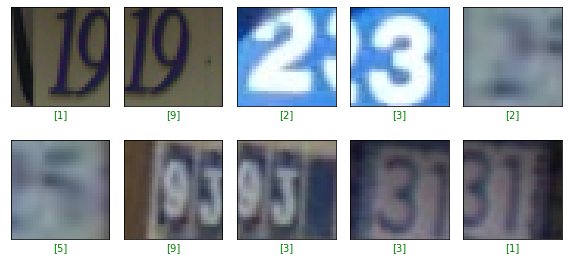

In [94]:
plt.figure(figsize=(8,4))
for i in range(10):
    plt.subplot(2, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(X_train[i, :, :, :, ]) 
    plt.xlabel(f'{y_train[i]}', color = 'green')
plt.tight_layout()        
plt.show()
    

In [95]:
X_train_gs = np.mean(X_train, 3).reshape(73257, 32, 32, 1)/255
X_test_gs = np.mean(X_test,3).reshape(26032, 32,32 ,1)/255
X_train_for_plotting = np.mean(X_train,3)

In [96]:
X_train_gs.shape

(73257, 32, 32, 1)

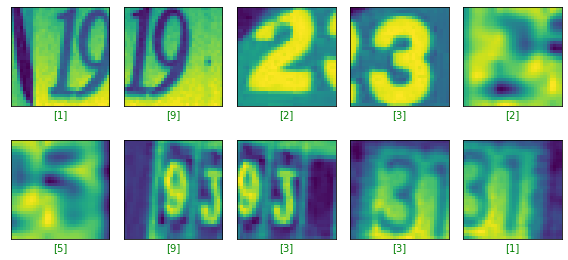

In [97]:
plt.figure(figsize=(8,4))
for i in range(10):
    plt.subplot(2, 5, i + 1, xticks=[], yticks=[])
    plt.imshow(X_train_for_plotting[i, :, :,  ]) 
    plt.xlabel(f'{y_train[i]}', color = 'green')
plt.tight_layout()        
plt.show()

In [98]:
X_train[0].shape

(32, 32, 3)

In [99]:
enc = OneHotEncoder().fit(y_train)
y_train_oh = enc.transform(y_train).toarray()
y_test_oh = enc.transform(y_test).toarray()

In [100]:
y_test_oh[0]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

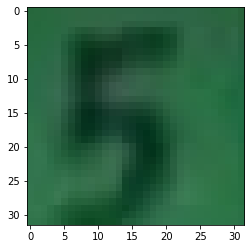

In [101]:
plt.imshow(X_test[0])

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [102]:
checkpoint = ModelCheckpoint(filepath = 'checkpoints/checkpoint', save_best_only=True, save_weights_only=True, monitor='val_loss', verbose=1)
earlystop = EarlyStopping(patience=5, monitor='loss')

In [103]:
model = Sequential([
    Flatten(input_shape=X_train[0].shape),
    Dense(128*4, activation='relu'),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_17 (Dense)             (None, 64)                32832     
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)               

In [104]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [105]:
history = model.fit(X_train, y_train_oh, callbacks=[checkpoint, earlystop], batch_size=128, validation_data=(X_test, y_test_oh), epochs=30)

Epoch 1/30
569/573 [============================>.] - ETA: 0s - loss: 2.0406 - accuracy: 0.2683
Epoch 00001: val_loss improved from inf to 2.59939, saving model to checkpoints/checkpoint
573/573 [==============================] - 6s 10ms/step - loss: 2.0387 - accuracy: 0.2691 - val_loss: 2.5994 - val_accuracy: 0.3024
Epoch 2/30
573/573 [==============================] - ETA: 0s - loss: 1.6031 - accuracy: 0.4552
Epoch 00002: val_loss improved from 2.59939 to 1.77156, saving model to checkpoints/checkpoint
573/573 [==============================] - 5s 9ms/step - loss: 1.6031 - accuracy: 0.4552 - val_loss: 1.7716 - val_accuracy: 0.4667
Epoch 3/30
573/573 [==============================] - ETA: 0s - loss: 1.4262 - accuracy: 0.5339
Epoch 00003: val_loss improved from 1.77156 to 1.53036, saving model to checkpoints/checkpoint
573/573 [==============================] - 5s 9ms/step - loss: 1.4262 - accuracy: 0.5339 - val_loss: 1.5304 - val_accuracy: 0.5225
Epoch 4/30
566/573 [=================

In [106]:
! dir

checkpoints  gdrive  sample_data


Text(0.5, 1.0, 'Loss')

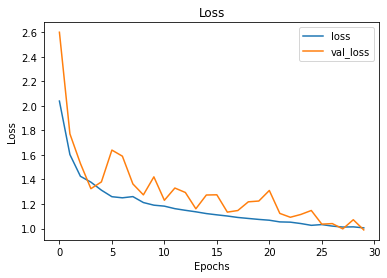

In [107]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

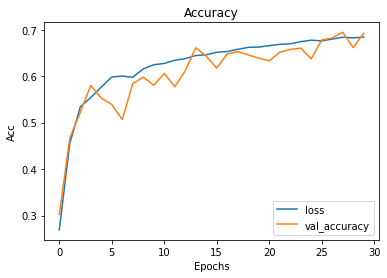

In [108]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['loss','val_accuracy'], loc='lower right')
plt.title("Accuracy")

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [109]:


model2 = Sequential([
    Conv2D(filters= 16, kernel_size= 3, activation='relu', input_shape=X_train[0].shape),
    MaxPool2D(pool_size= (3,3), strides=1),
    Conv2D(filters= 32, kernel_size = 3, padding='valid', strides=1, activation='relu'),
    MaxPool2D(pool_size = (1,1), strides = 3),
    BatchNormalization(),
    Conv2D(filters= 32, kernel_size = 3, padding='valid', strides=2, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    Dense(10, activation='softmax')
])

In [110]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 9, 9, 32)          128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 32)         

In [111]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [112]:
callback1 = ModelCheckpoint(filepath='CNNweights', save_best_only=True, save_weights_only=True, save_freq=5000,monitor='val_acc')
callback2 = EarlyStopping(monitor='loss',patience=7, verbose=1)

In [113]:
X_train.shape

(73257, 32, 32, 3)

In [114]:
history = model2.fit(X_train, y_train_oh, callbacks=[checkpoint, earlystop], batch_size=256, validation_data=(X_test, y_test_oh), epochs=30)

Epoch 1/30
285/287 [============================>.] - ETA: 0s - loss: 1.8455 - accuracy: 0.3551
Epoch 00001: val_loss did not improve from 0.98920
287/287 [==============================] - 6s 20ms/step - loss: 1.8430 - accuracy: 0.3561 - val_loss: 1.3453 - val_accuracy: 0.5624
Epoch 2/30
287/287 [==============================] - ETA: 0s - loss: 1.0501 - accuracy: 0.6603
Epoch 00002: val_loss did not improve from 0.98920
287/287 [==============================] - 5s 18ms/step - loss: 1.0501 - accuracy: 0.6603 - val_loss: 1.5492 - val_accuracy: 0.5148
Epoch 3/30
287/287 [==============================] - ETA: 0s - loss: 0.8436 - accuracy: 0.7356
Epoch 00003: val_loss improved from 0.98920 to 0.77412, saving model to checkpoints/checkpoint
287/287 [==============================] - 5s 18ms/step - loss: 0.8436 - accuracy: 0.7356 - val_loss: 0.7741 - val_accuracy: 0.7603
Epoch 4/30
285/287 [============================>.] - ETA: 0s - loss: 0.7423 - accuracy: 0.7701
Epoch 00004: val_loss d

Text(0.5, 1.0, 'Loss')

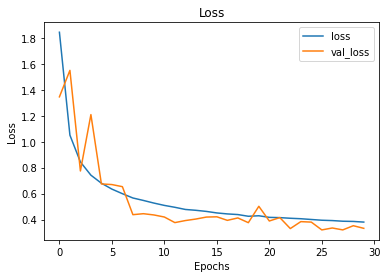

In [115]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'], loc='upper right')
plt.title("Loss")

Text(0.5, 1.0, 'Accuracy')

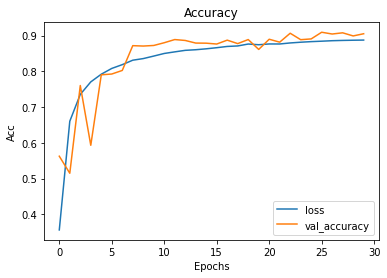

In [116]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['loss','val_accuracy'], loc='lower right')
plt.title("Accuracy")

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [117]:
! ls checkpoints

checkpoint  checkpoint.data-00000-of-00001  checkpoint.index


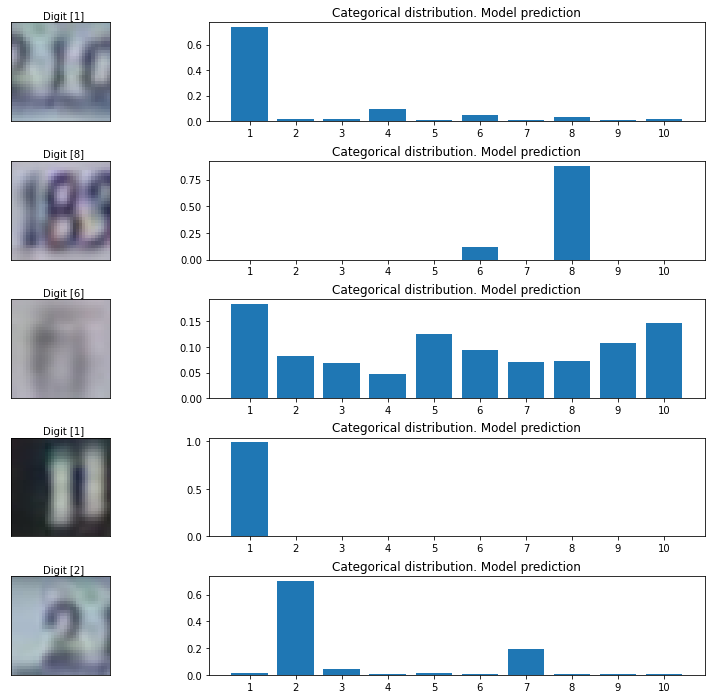

In [118]:
random_inx = np.random.choice(10, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

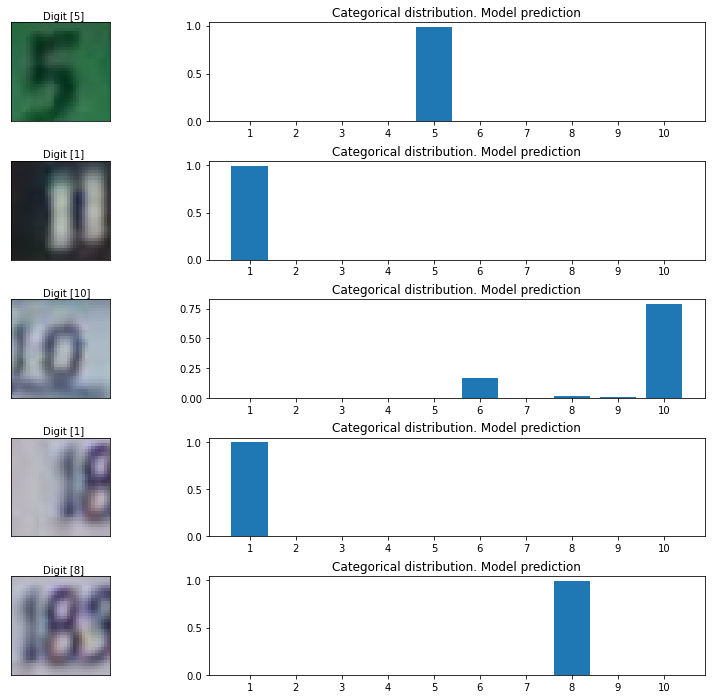

In [119]:
num_test_images = X_test.shape[0]

random_inx = np.random.choice(10, 5)
random_test_images = X_test[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model2.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()

In [120]:
!jupyter nbconvert --to PDF "/content/gdrive/My Drive/Colab Notebooks/capstone_imperial.ipynb"

[NbConvertApp] Converting notebook /content/gdrive/My Drive/Colab Notebooks/capstone_imperial.ipynb to PDF
[NbConvertApp] Support files will be in capstone_imperial_files/
[NbConvertApp] Making directory ./capstone_imperial_files
[NbConvertApp] Making directory ./capstone_imperial_files
[NbConvertApp] Making directory ./capstone_imperial_files
[NbConvertApp] Making directory ./capstone_imperial_files
[NbConvertApp] Making directory ./capstone_imperial_files
[NbConvertApp] Writing 84509 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 172756 bytes to /content/gdrive/My Drive/Colab Notebooks/capstone_imperial.pdf
